In [1]:
import os
import pandas as pd
import json
os.chdir("..")
%pwd

'/home/jupyter/crisp'

In [2]:
from main import run
from synthetic.facebook_synthetic_data_generator import generator_example
from synthetic.facebook_synthetic_data import DATASETS

In [3]:
# synthetic dataset parameters 
n_example = 1
dim_inv=20
n_bin=1
dim_spu=1000
n_exp_train=500 #int(2e2)
n_exp_test=500
n_env=5
save_dir= 'data/synthetic'
test=False 

In [4]:
output_data_regime = ["real-valued", "binary", "binary", "real-valued", "multi-class"][n_example-1]
verbose = 1

In [5]:
# (re) create synthetic dataset for experiment
generator_example(n_example, dim_inv, dim_spu, n_exp_train, n_env ,save_dir, test=False)#, n_bin) # generate pickle with train data
generator_example(n_example, dim_inv, dim_spu, n_exp_test, n_env ,save_dir, test=True)  # generate pickle with test data
outfile_train = os.path.join(save_dir,"data_fb_example_%s_dim_inv_%s_dim_spu_%s_n_exp_%s_n_env_%s_test_%s.pickle" %(n_example, dim_inv, dim_spu, n_exp_train, n_env,"False"))
outfile_test = os.path.join(save_dir,"data_fb_example_%s_dim_inv_%s_dim_spu_%s_n_exp_%s_n_env_%s_test_%s.pickle" %(n_example, dim_inv, dim_spu, n_exp_test, n_env,"True"))

Environments variables: {'E0': 0.1, 'E1': 1.5, 'E2': 2, 'E3': 0.30815539086172433, 'E4': 2.016811860476012}
torch.Size([100, 1020])
torch.Size([100, 1020])
torch.Size([100, 1020])
torch.Size([100, 1020])
torch.Size([100, 1020])
Generated Synthetic Data according to the Facebook setup Example: 1
Environments variables: {'E0': 0.1, 'E1': 1.5, 'E2': 2, 'E3': 0.30815539086172433, 'E4': 2.016811860476012}
torch.Size([100, 1020])
torch.Size([100, 1020])
torch.Size([100, 1020])
torch.Size([100, 1020])
torch.Size([100, 1020])
Generated Synthetic Data according to the Facebook setup Example: 1


In [6]:
df_train = pd.read_pickle(outfile_train)
df_test = pd.read_pickle(outfile_test)

In [7]:
df_train.head()

,Causal_0,Causal_1,Causal_2,Causal_3,Causal_4,Causal_5,Causal_6,Causal_7,Causal_8,Causal_9,...,Non_causal_993,Non_causal_994,Non_causal_995,Non_causal_996,Non_causal_997,Non_causal_998,Non_causal_999,env_split,Subj_ID,Target
0,-0.036335,0.063274,0.047913,0.116305,0.028134,-0.078492,-0.025860,0.159238,-0.084501,-0.205224,...,-0.892347,-1.887859,-0.178988,-1.760875,-1.094646,-0.976560,-1.111532,0.0,0.0,0.001158
1,-0.104488,0.059223,0.075557,0.080219,0.138370,0.103289,-0.161543,-0.015248,-0.051410,-0.198861,...,-1.135996,-0.423550,-1.487206,-0.994670,-0.662650,1.224222,1.909324,0.0,1.0,-8.954418
2,-0.036065,-0.043585,-0.050946,-0.091078,-0.003741,0.029283,0.028384,-0.058455,-0.063879,0.280253,...,-1.096630,-0.451862,1.650665,-0.459826,1.943040,-1.395653,-0.166597,0.0,2.0,-3.029216
3,0.068710,0.026434,0.061683,0.054293,-0.005290,0.158240,0.033169,-0.108518,0.074859,0.179911,...,0.527834,-1.258697,0.899656,-1.238072,-0.863659,-1.421540,-0.855871,0.0,3.0,-4.418277
4,0.080706,0.040781,-0.007407,-0.017751,0.051482,0.004494,0.003628,0.111546,0.013433,0.129075,...,-1.389605,-1.363936,-0.294234,0.393527,-1.168013,2.443986,1.714018,0.0,4.0,-5.525867


In [8]:
# define config
config = {
    "name": "Example Experiment for AH casual ensemble",
    "short_name": "ah_experiment_notebook",
    "bucket_project": "fdl-us-astronaut-health",
    "bucket_name": "ah_21_data",
    "bucket_path": "gs://ah_21_data",
    "verbose": verbose,
    "test_val_split": [0.1, 0.1],
    "per_variant_experiment": False,
    "data_options": {
        #'dataset_fp': '../data/test_multiclass.pkl',
        'synthetic_train_test_split' : True,
        #'dataset_fp' : outfile,
        'dataset_fp_train' : outfile_train,
        'dataset_fp_test' : outfile_test,
        'output_data_regime' : output_data_regime,
        'subject_keys': 'Subj_ID',
        'targets': ['Target'],
        #'predictors': ['All'],
        'predictors': list(df_train.columns[0:dim_inv+dim_spu]),
        'environments': ['env_split'],
        'exclude': ['Subj_ID']
    },
    "feature_selection_options": {
        "max_features": 20,
        "verbose": verbose,
        "seed": 12
    },
    "ensemble_options": {
        "models": ["ICP", "LIRM"],
        "LIRM" : {
            "use_icp_initialization": False,
            "verbose": verbose,
            "n_iterations": 1000,
            "seed": 0,
            "lr": 0.001,
            "cuda": False,
            "output_data_regime" : output_data_regime,
        },
        "DCF" : {
            "minP": 0.1,
            "maxP": 0.9,
            "minFeatures": 1,
            "minAccuracy": 0.5,
            "seed": 0,
            "verbose": verbose,
            "target": ["Target"],
            "output_pvals": False,
            "output_data_regime" : output_data_regime,
        },
        "NLICP" : {
            "max_set_size": 2,
            "alpha": 0.05,
            "seed": 12,
            "verbose": verbose,
            "method": "MLP",
            "hidden_dim": 256,
            "output_data_regime" : output_data_regime,
        },
        "LICP" : {
            "max_set_size": 4,
            "alpha": 0.05,
            "seed": 12,
            "verbose": verbose,
            "output_data_regime" : output_data_regime,
        },
    },
    "use_cloud":False,
    "results_directory": "results/"
}

In [9]:
config.get("ensemble_options").get("LIRM")

{'use_icp_initialization': False,
 'verbose': 1,
 'n_iterations': 1000,
 'seed': 0,
 'lr': 0.001,
 'cuda': False,
 'output_data_regime': 'real-valued'}

In [10]:
# write config
with open('experiment_configs/ensemble_test_run.json', 'w') as f:
    json.dump(config, f)

Running a per sample experiment
Using synthetic dataset train/test split
Loaded  5  train environments
Env  0  has  77  samples
X shape  (77, 20)  y shape  (77, 1)
Env  1  has  83  samples
X shape  (83, 20)  y shape  (83, 1)
Env  2  has  78  samples
X shape  (78, 20)  y shape  (78, 1)
Env  3  has  82  samples
X shape  (82, 20)  y shape  (82, 1)
Env  4  has  80  samples
X shape  (80, 20)  y shape  (80, 1)
Loaded test set, X shape: (500, 20)  y shape:  (500, 1)
Running Ensemble with the following models:  ['ICP', 'LIRM']
Checking for features with zero variance
Across all environments the following columns had zero variance: []
Running a per sample experiment
Using synthetic dataset train/test split


/home/jupyter/crisp/utils/CorrelationToTarget.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_x = np.array(all_x)
/home/jupyter/crisp/utils/CorrelationToTarget.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_y = np.array(all_y)


Loaded  5  train environments
Env  0  has  77  samples
X shape  (77, 20)  y shape  (77, 1)
Env  1  has  83  samples
X shape  (83, 20)  y shape  (83, 1)
Env  2  has  78  samples
X shape  (78, 20)  y shape  (78, 1)
Env  3  has  82  samples
X shape  (82, 20)  y shape  (82, 1)
Env  4  has  80  samples
X shape  (80, 20)  y shape  (80, 1)
Loaded test set, X shape: (500, 20)  y shape:  (500, 1)
Running correlation analysis
Intersection: []
Running a per sample experiment
Using synthetic dataset train/test split
Loaded  5  train environments
Env  0  has  77  samples
X shape  (77, 20)  y shape  (77, 1)
Env  1  has  83  samples
X shape  (83, 20)  y shape  (83, 1)
Env  2  has  78  samples
X shape  (78, 20)  y shape  (78, 1)
Env  3  has  82  samples
X shape  (82, 20)  y shape  (82, 1)
Env  4  has  80  samples
X shape  (80, 20)  y shape  (80, 1)
Loaded test set, X shape: (500, 20)  y shape:  (500, 1)
Running IRM (Feature Reduction Mode)
NLIRM using MLP
0               0.60534         0.00260       

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([400])) that is different to the input size (torch.Size([400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


{'solution': True, 'intersection': False, 'feature_coeffients': array([[-0.03674106, -0.03445562,  0.008304  ,  0.00402423,  0.00713528,
         0.00142999,  0.01607098,  0.00621179,  0.00102748,  0.02307309,
         0.01415437, -0.01813148,  0.00351083,  0.01208775,  0.0201993 ,
         0.00957753, -0.0114957 ,  0.03630226,  0.01949532,  0.00600181]],
      dtype=float32), 'selected_features': array(['Non_causal_182', 'Non_causal_203', 'Non_causal_525', 'Causal_4',
       'Non_causal_718', 'Non_causal_530', 'Non_causal_943',
       'Non_causal_673', 'Causal_6', 'Non_causal_739', 'Non_causal_962',
       'Non_causal_323', 'Non_causal_862', 'Non_causal_853',
       'Non_causal_757', 'Non_causal_295', 'Non_causal_153',
       'Non_causal_228', 'Non_causal_438', 'Non_causal_74'], dtype='<U14'), 'selected_feature_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'to_bucket': {'method': 'Linear ICP', 'features': ['Non_causal_182', 'Non_causal_203', 'Non_ca

ValueError: Length of values (1) does not match length of index (20)

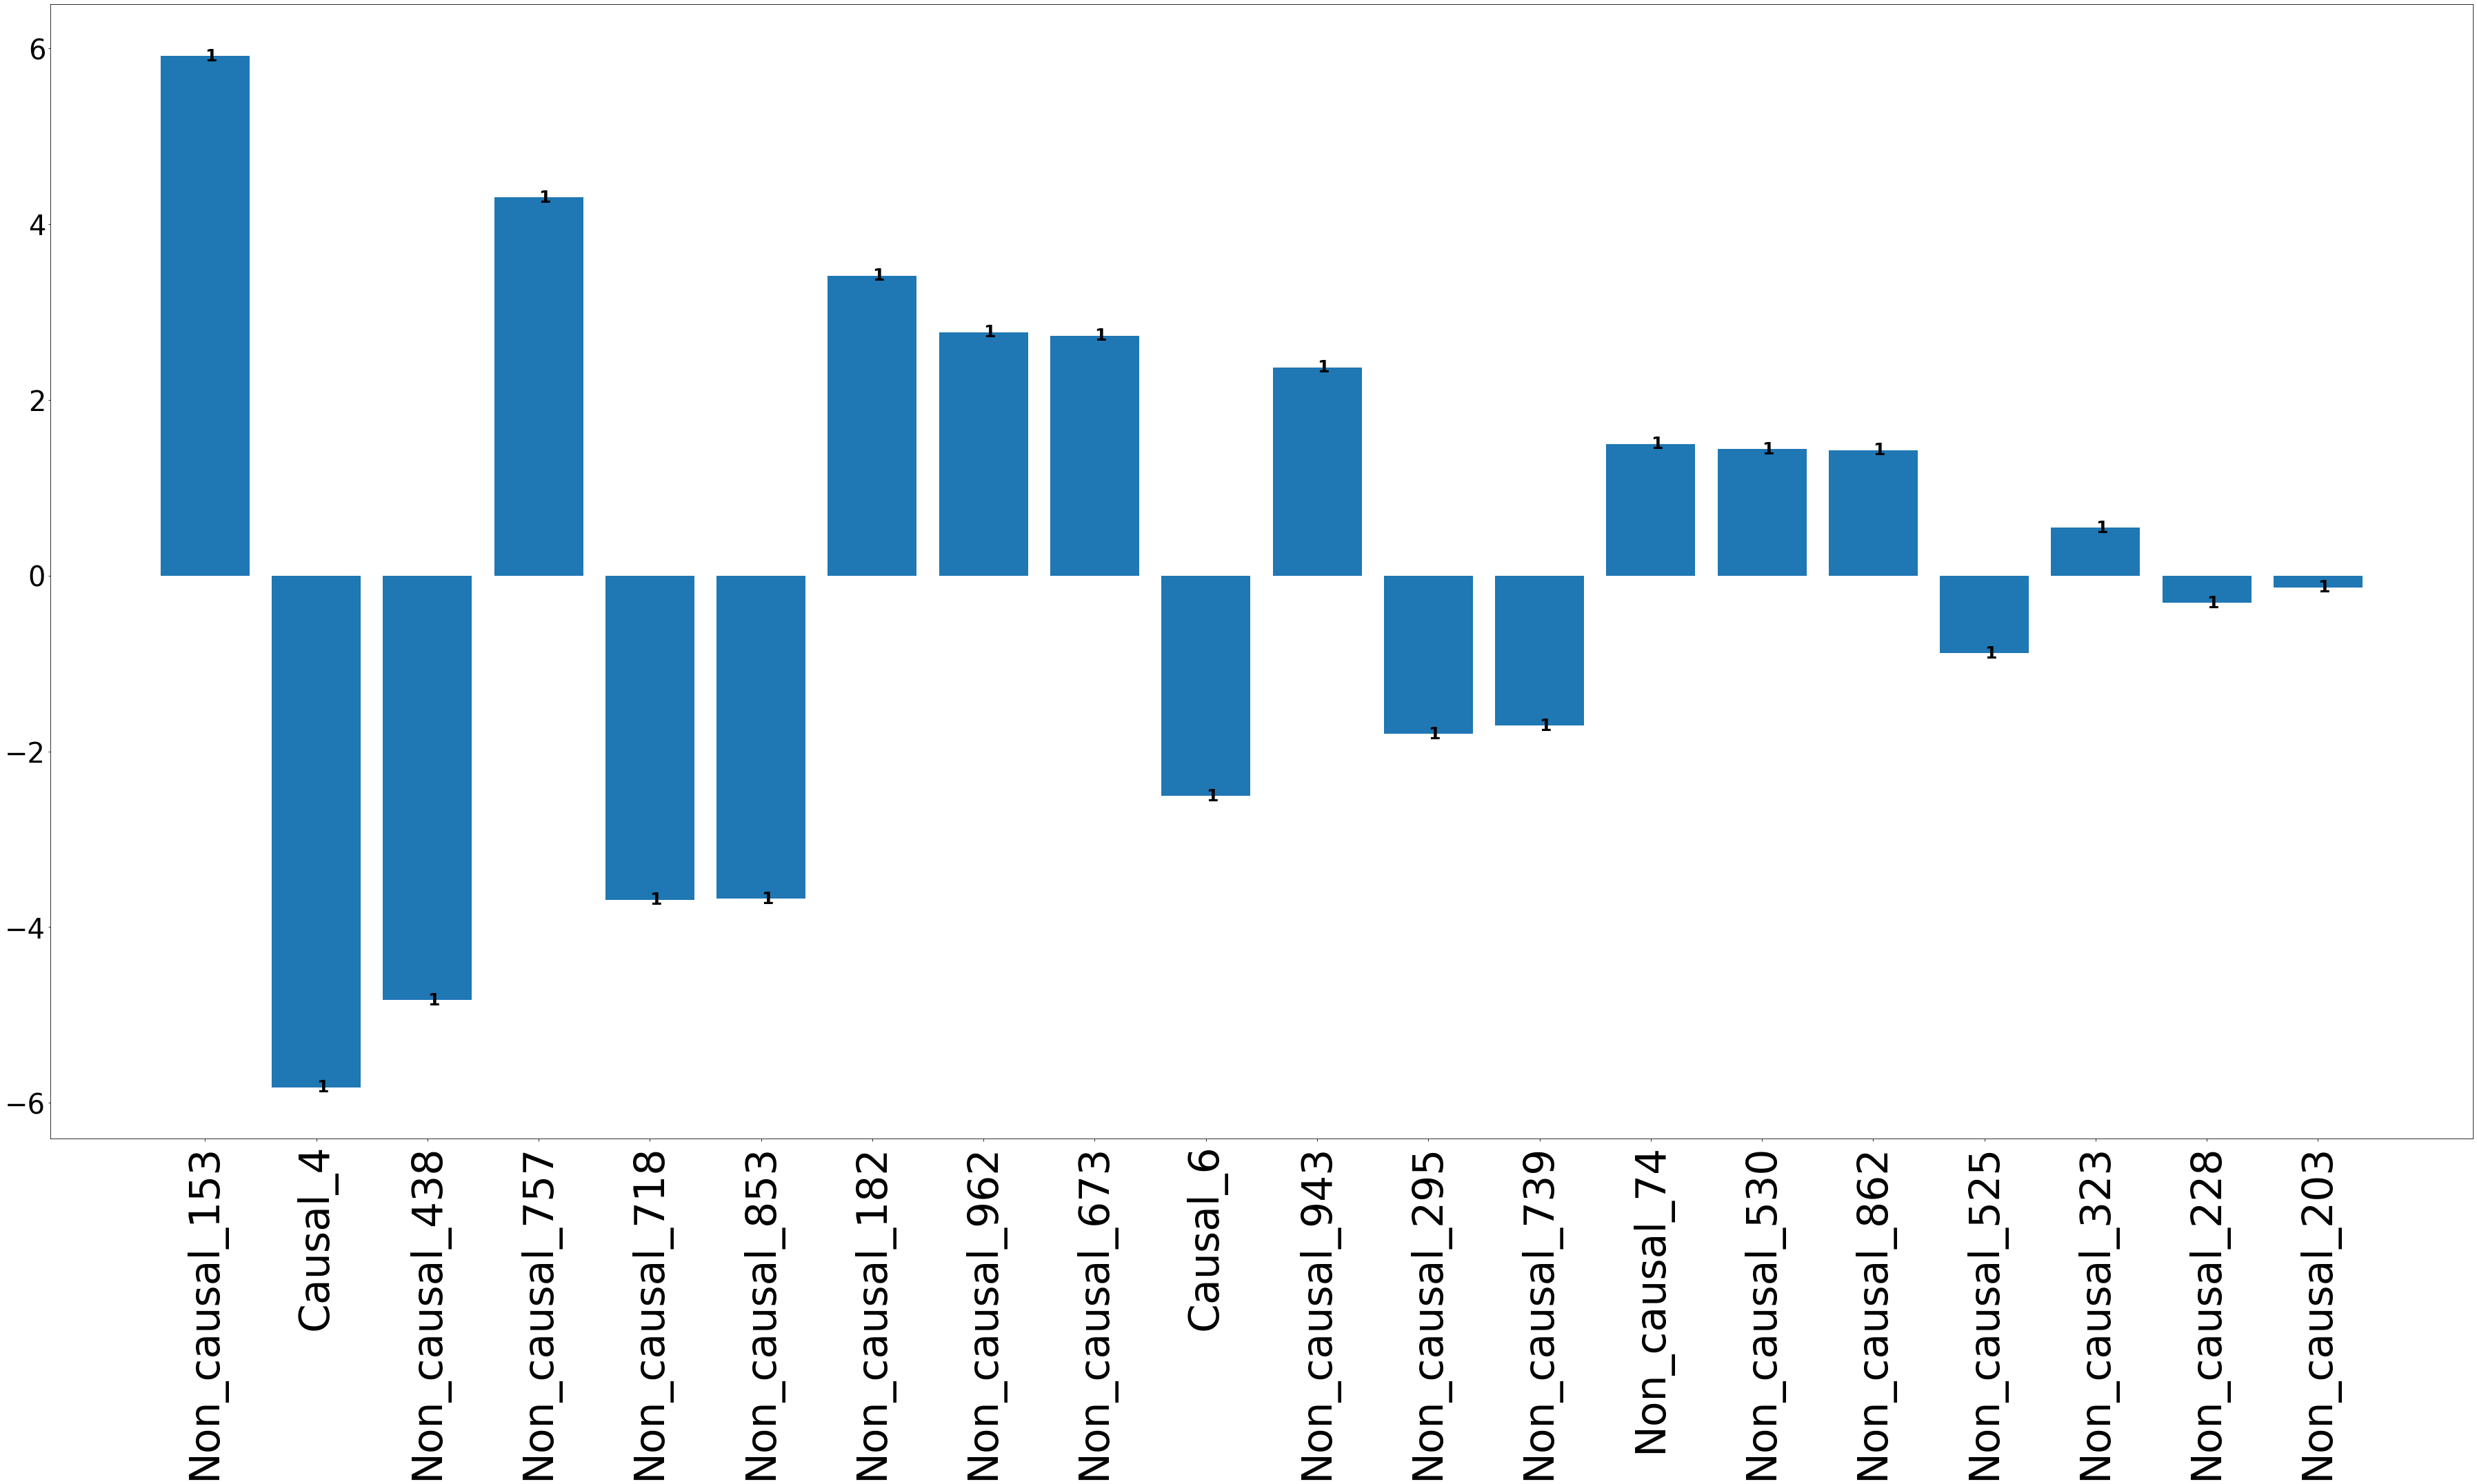

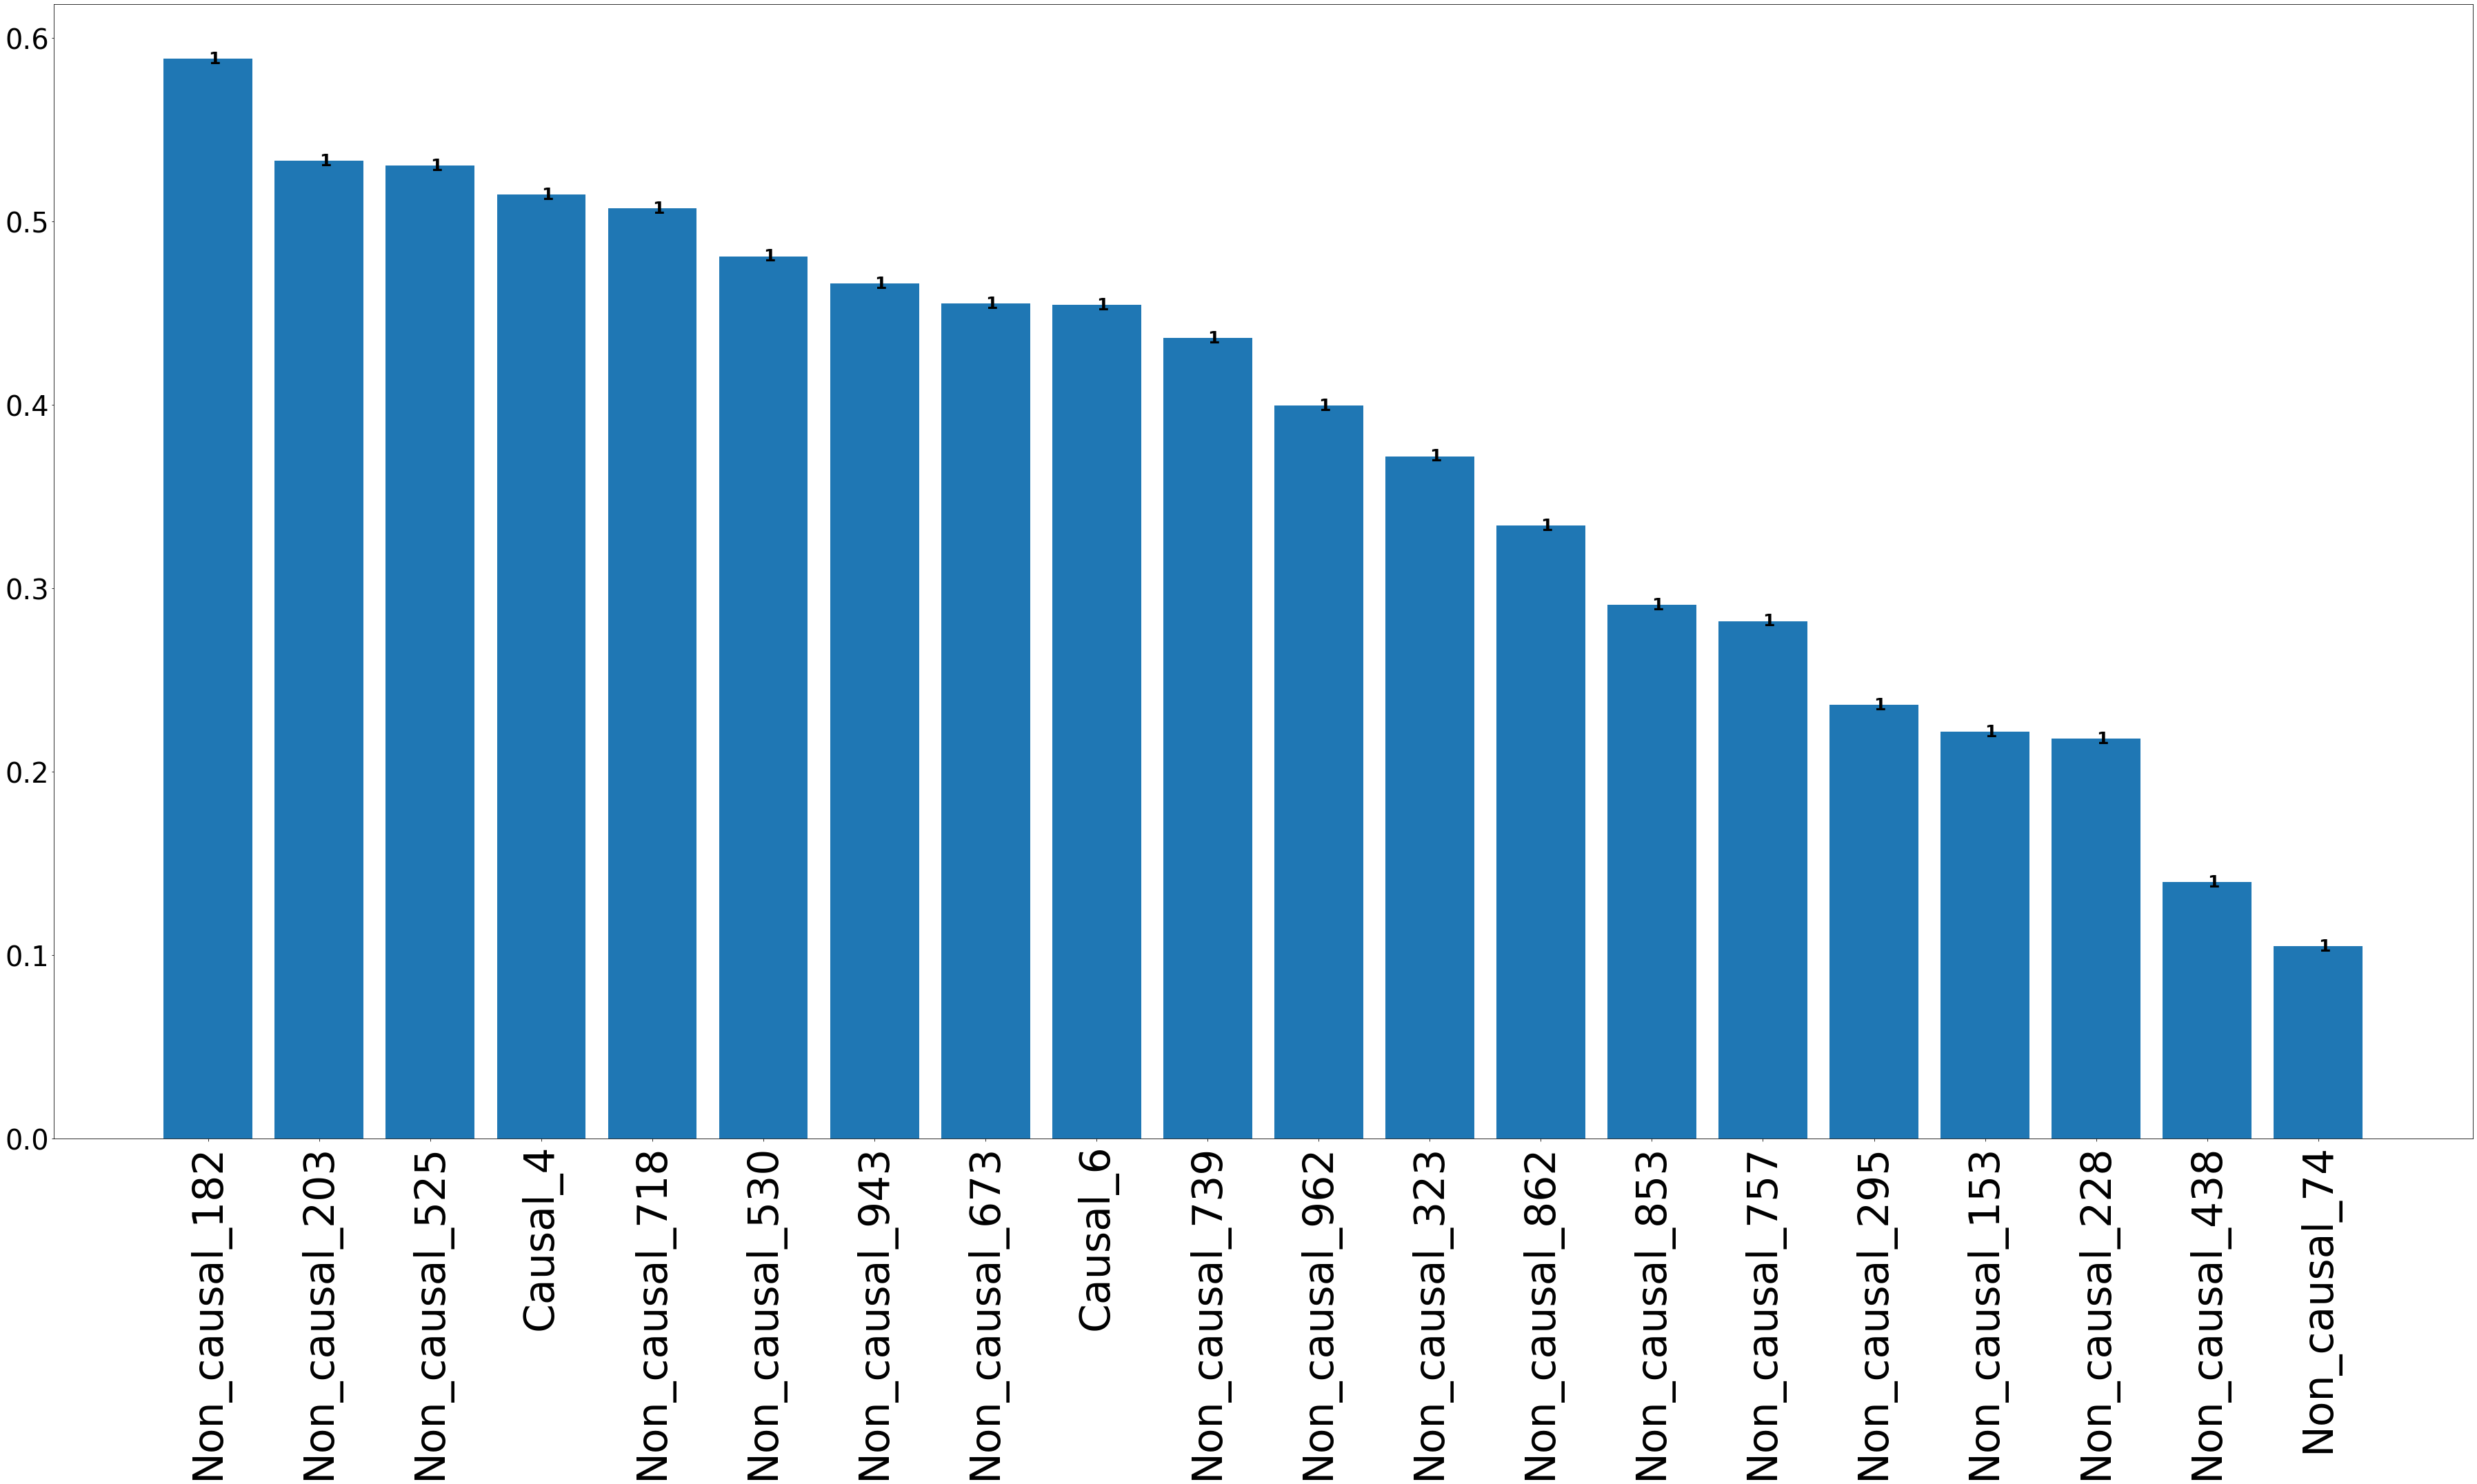

In [12]:
# run crisp
run(config,1)

In [ ]:
config['data_options']['dataset_fp']

In [15]:
'_'.join('Causal_3_Target'.split('_')[:-1])

'Causal_3'